# PCA for NSL-KDD

Dimensionality reduction pipeline that feeds later anomaly detection steps.


## Imports and plotting defaults


In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

DATA_DIR = Path('../data')
RANDOM_STATE = 42

## Load preprocessed datasets

Load encoded/transformed data from preprocessing (not yet normalized).


In [8]:
train_df = pd.read_csv(DATA_DIR / 'preproc_kdd_train.csv')
test_df = pd.read_csv(DATA_DIR / 'preproc_kdd_test.csv')

print(f'Train: {train_df.shape} | Test: {test_df.shape}')
print('\nAttack distribution (top 5):')
print('TRAIN:', train_df['attack_type'].value_counts().head().to_dict())
print('TEST: ', test_df['attack_type'].value_counts().head().to_dict())

Train: (125973, 40) | Test: (22544, 40)

Attack distribution (top 5):
TRAIN: {'normal': 67343, 'neptune': 41214, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931}
TEST:  {'normal': 9711, 'neptune': 4657, 'guess_passwd': 1231, 'mscan': 996, 'warezmaster': 944}


## Scale features

Normalize all numeric features except one-hot encoded columns (protocol_tcp, protocol_udp stay binary 0/1).


In [9]:
# Exclude binary / one-hot columns from normalization
binary_features = [
  'protocol_tcp',
  'protocol_udp',
  'land',
  'logged_in',
  'root_shell',
  'is_host_login',
  'is_guest_login',
]
all_numeric = train_df.select_dtypes(include=[np.number]).columns.tolist()
features_to_scale = [
  col for col in all_numeric if col not in binary_features and col != 'attack_type'
]

# Fit scaler on training data
scaler = StandardScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

print(f'Normalized {len(features_to_scale)} features (excluded one-hot columns)')

Normalized 32 features (excluded one-hot columns)


## Extract features and labels

Separate features from labels and convert attack_type to binary attack_flag (0=normal, 1=attack).


In [10]:
# Extract features (drop attack_type column)
X_train = train_df.drop(columns='attack_type').to_numpy()
X_test = test_df.drop(columns='attack_type').to_numpy()

# Convert attack_type to binary: 0=normal, 1=attack
y_train = (train_df['attack_type'] != 'normal').astype(int)
y_test = (test_df['attack_type'] != 'normal').astype(int)

print(f'Features: {X_train.shape} (train), {X_test.shape} (test)')
print(f'Attack rate: {y_train.mean():.2%} (train), {y_test.mean():.2%} (test)')

Features: (125973, 39) (train), (22544, 39) (test)
Attack rate: 46.54% (train), 56.92% (test)


## Determine optimal components

Fit PCA and find number of components needed for 95% variance.


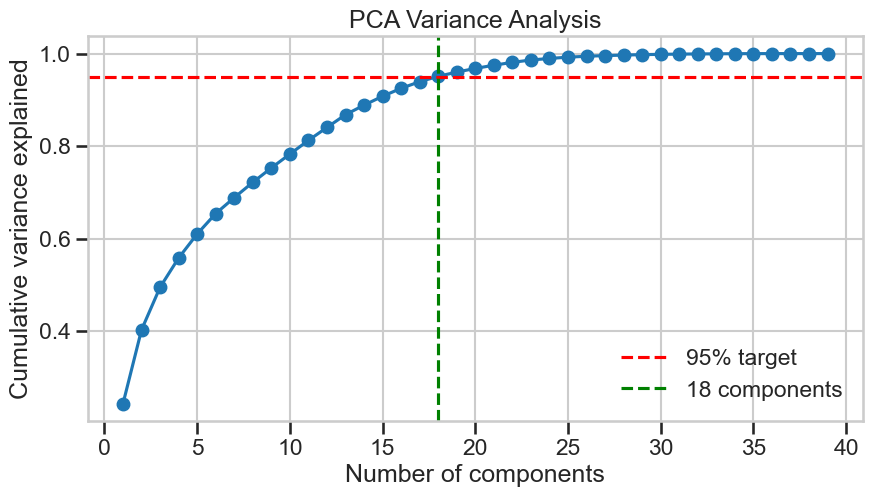

Components for 95% variance: 18


In [11]:
# Fit full PCA and compute cumulative variance
pca_full = PCA().fit(X_train)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = int(np.argmax(cum_var >= 0.95) + 1)

# Plot variance curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
ax.axhline(0.95, color='r', linestyle='--', label='95% target')
ax.axvline(
  n_components_95, color='g', linestyle='--', label=f'{n_components_95} components'
)
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative variance explained')
ax.set_title('PCA Variance Analysis')
ax.legend()
plt.show()

print(f'Components for 95% variance: {n_components_95}')

In [12]:
# Fit PCA with optimal components and transform both datasets
pca = PCA(n_components=n_components_95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# Helper function to create PCA dataframe with attack_flag
def create_pca_df(X_pca, y):
  cols = [f'pc{i:02d}' for i in range(1, X_pca.shape[1] + 1)]
  df = pd.DataFrame(X_pca, columns=cols)
  df['attack_flag'] = y.to_numpy()
  return df


# Create and save dataframes
train_pca_df = create_pca_df(X_train_pca, y_train)
test_pca_df = create_pca_df(X_test_pca, y_test)

train_pca_df.to_csv(DATA_DIR / 'pca_kdd_train.csv', index=False)
test_pca_df.to_csv(DATA_DIR / 'pca_kdd_test.csv', index=False)

print(f'Saved train: {train_pca_df.shape} -> {DATA_DIR / "PCA-nsl_kdd_train.csv"}')
print(f'Saved test:  {test_pca_df.shape} -> {DATA_DIR / "PCA-nsl_kdd_test.csv"}')

Saved train: (125973, 19) -> ../data/PCA-nsl_kdd_train.csv
Saved test:  (22544, 19) -> ../data/PCA-nsl_kdd_test.csv
